# Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train.shape, test.shape, submission.shape

((19219, 35), (12814, 28), (12814, 8))

In [10]:
train.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

## Feature Engineering

In [11]:
train1 = train.copy()

In [12]:
train1.insert(1, 'delta-X', train1['X_Maximum']-train1['X_Minimum'])
train1.insert(2, 'delta-Y', train1['Y_Minimum']-train1['Y_Maximum'])
train1.insert(3, 'delta-Lumino', train1['Maximum_of_Luminosity']-train1['Minimum_of_Luminosity'])
train1

,id,delta-X,delta-Y,delta-Lumino,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,6,-5,27,584,590,909972,909977,16,8,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,8,-22,41,808,816,728350,728372,433,20,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,153,-68,112,39,192,2212076,2212144,11388,705,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,8,-27,20,781,789,3353146,3353173,210,16,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,20,-45,29,1540,1560,618457,618502,521,72,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19214,8,-9,18,749,757,143210,143219,17,4,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19215,12,-12,29,723,735,2488529,2488541,231,17,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19216,25,-74,53,6,31,1578055,1578129,780,114,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19217,9,-12,44,9,18,1713172,1713184,126,13,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


In [13]:
train1.drop(['id', 'X_Maximum', 'X_Minimum', 'Y_Minimum', 'Y_Maximum', 'Maximum_of_Luminosity', 'Minimum_of_Luminosity'], axis=1, inplace=True)
train1

,delta-X,delta-Y,delta-Lumino,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,6,-5,27,16,8,5,2274,1358,0,1,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,8,-22,41,433,20,54,44478,1687,1,0,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,153,-68,112,11388,705,420,1311391,1400,0,1,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,8,-27,20,210,16,29,3202,1387,0,1,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,20,-45,29,521,72,67,48231,1692,0,1,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,8,-9,18,17,4,4,2193,1360,0,0,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,12,-12,29,231,17,26,27135,1652,1,0,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,25,-74,53,780,114,98,71112,1358,0,1,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,9,-12,44,126,13,26,14808,1692,1,0,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


# split dataset to X,y

In [14]:
train1.columns

Index(['delta-X', 'delta-Y', 'delta-Lumino', 'Pixels_Areas', 'X_Perimeter',
       'Y_Perimeter', 'Sum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [15]:
X1 =  train1[['delta-X', 'delta-Y', 'delta-Lumino', 'Pixels_Areas', 'X_Perimeter',
       'Y_Perimeter', 'Sum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
y1 = train1[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']]

# Outlier detection and replacing

C:\Users\Darab Store\AppData\Local\Temp\ipykernel_2608\932726798.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1[col][upper_flags] = upper_cap
C:\Users\Darab Store\AppData\Local\Temp\ipykernel_2608\932726798.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1[col][lower_flags] = lower_cap
C:\Users\Darab Store\AppData\Local\Temp\ipykernel_2608\932726798.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1[col][upper_flags

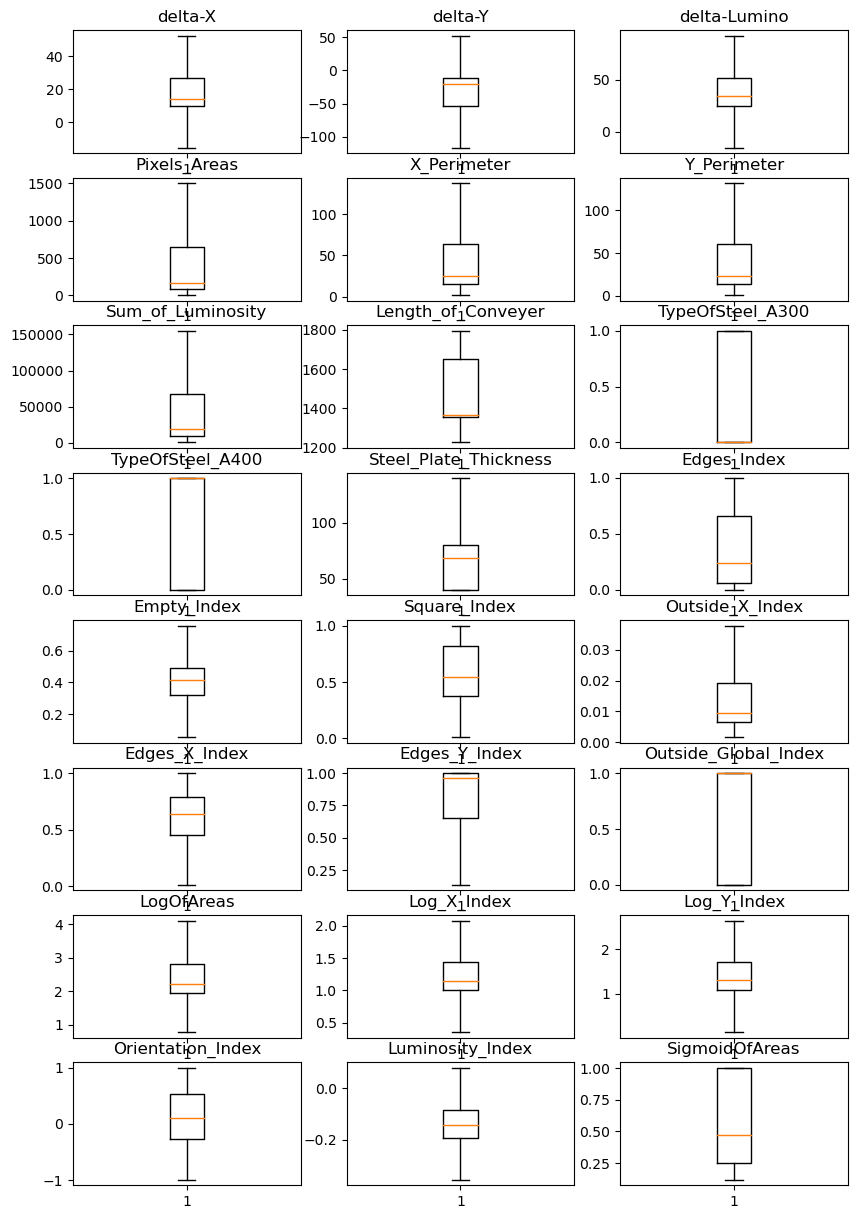

In [17]:
for col in X1.columns:
    Q3 = X1[col].quantile(0.75)
    Q1 = X1[col].quantile(0.25)
    IQR = Q3 - Q1
    upper_cap = Q3 + 1.5*IQR
    lower_cap = Q1 - 1.5*IQR

    upper_flags = X1[col] > upper_cap
    lower_flags = X1[col] < lower_cap

    X1[col][upper_flags] = upper_cap
    X1[col][lower_flags] = lower_cap

fig, axes = plt.subplots(8, 3, figsize=(10,15))
axes_flat = axes.flatten()
    
for i, col in enumerate(X1.columns):
    ax = axes_flat[i]
    ax.boxplot(X1[col])
    ax.set_title(col)

## Normalization

In [17]:
norm_sta = StandardScaler()
norm_minmax = MinMaxScaler()

In [ ]:
X1_sta = norm_sta.fit_transform(X1)
X1_minmax = norm_minmax.fit_transform(X1)